# Thermal Exploration using TidalPy
In this notebook we will see how we can use TidalPy's object oriented approach to build a layered planet. We will then apply different temperatures to its mantle layer and see how its physical properties and tidal heating potential are affected.

### Build the Planet
For this example we will build a simple version of Io. We will use the pre-built TidalPy configuration for "io_simple"; its configurations will be printed below.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, widgets
%matplotlib widget 
from TidalPy.structures import build_world, build_from_world
from TidalPy.structures import Orbit

print_configs = False

In [2]:
from pprint import pprint
io = build_world('io_simple')

if print_configs:
    print('Complex Compliance Model Parameters:')
    pprint(io.Mantle.rheology.complex_compliance_model.config)
    print('\nSolid Viscosity Model Parameters:')
    pprint(io.Mantle.rheology.viscosity_model.config)
    print('\nPartial Melting Model Parameters:')
    pprint(io.Mantle.rheology.partial_melting_model.config)

### Plot the Planet's Interior Structure
Remember this is just a simple version of Io (no density as function of pressure)

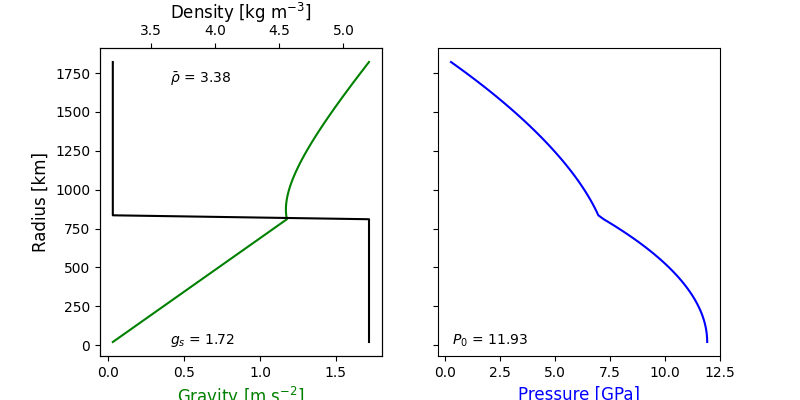

In [3]:
_ = io.paint()

### Set the Mantle's Temperature and Plot its Viscoelastic Properties

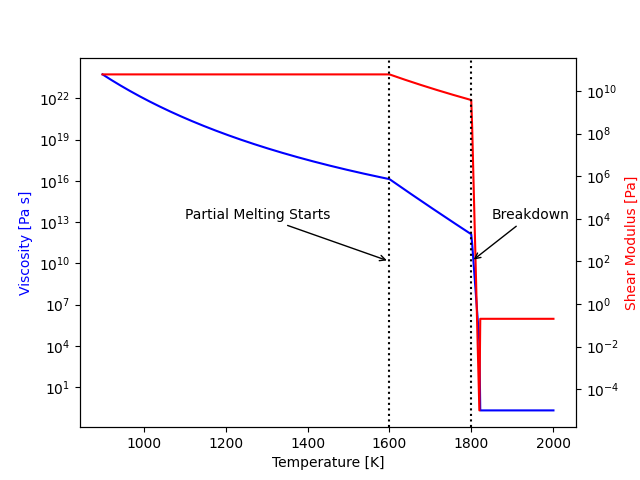

In [4]:
temperature = np.linspace(900., 2000., 500)
io.Mantle.set_state(temperature=temperature)

# Plot the results
fig, ax = plt.subplots()
ax.set(xlabel='Temperature [K]', ylabel='Viscosity [Pa s]', yscale='log')
ax.yaxis.label.set_color('b')
ax_2 = ax.twinx()
ax_2.set(yscale='log', ylabel='Shear Modulus [Pa]')
ax_2.yaxis.label.set_color('r')

io_visco_vs_temp = io.Mantle.viscosity
io_shear_vs_temp = io.Mantle.shear_modulus
ax.plot(temperature, io_visco_vs_temp, c='b')
ax_2.plot(temperature, io_shear_vs_temp, c='r')

# Add line where partial melting starts
ax_2.axvline(x=1600., ls=':', c='k')
ax_2.annotate('Partial Melting Starts', (1600., 1.e2), (1100, 1.e4), arrowprops={'arrowstyle':'->'})
ax_2.axvline(x=1800., ls=':', c='k')
ax_2.annotate('Breakdown', (1800., 1.e2), (1850, 1.e4), arrowprops={'arrowstyle':'->'})
plt.show()

## Calculate Tidal Heating as a function of Temperature for Io
Using a more realistic interior model for Io, we will now calculate tidal heating as a function of mantle temperature.
This assumes Io's mantle is a homogeneous layer that follows the shear & viscosity vs. temperature relationship seen in the last figure.

Warning from file 'C:\Users\joepr\anaconda3\envs\tpy6py311\Lib\site-packages\burnman\classes\mineral.py', line 242:
You are trying to calculate shear modulus for Fe_Dewaele when it is exactly zero. 
If Fe_Dewaele is a liquid, then you can safely ignore this warning, but consider 
calculating bulk modulus or bulk sound rather than Vp or Vs. 
If Fe_Dewaele is not a liquid, then shear modulus calculations for the 
underlying equation of state (Vinet) have not been implemented, 
and Vp and Vs estimates will be incorrect.

One or more heat sources were not set for Layer Mantle (rock in Io_variant (BurnManWorld); loc=1).
One or more heat sources were not set for Layer Mantle (rock in Io_variant (BurnManWorld); loc=1).
Warning from file 'C:\Users\joepr\anaconda3\envs\tpy6py311\Lib\site-packages\TidalPy\stellar\insolation.py', line 53:
invalid value encountered in power

One or more heat sources were not set for Layer Mantle (rock in Io_variant (BurnManWorld); loc=1).
One or more heat sources 

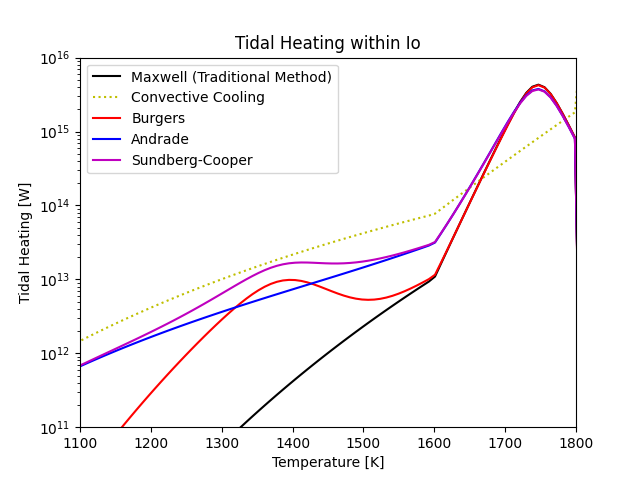

In [5]:
plot_convection = True
plot_radiogenics = False

# Build a new Io
io_base = build_world('io')

# Setup domain and plot
temperature = np.linspace(1000., 1850., 100)
fig2, ax2 = plt.subplots()
ax2.set(xlabel='Temperature [K]', ylabel='Tidal Heating [W]', yscale='log', ylim=(1e11, 1e16), xlim=(1100, 1800),
        title='Tidal Heating within Io')

# Lets show how different rheological models can impact tidal heating
fixed_q = 10.
rheologies = {
    'maxwell': ('Maxwell (Traditional Method)', 'k'),
    'burgers': ('Burgers', 'r'),
    'andrade': ('Andrade', 'b'),
    'sundberg': ('Sundberg-Cooper', 'm')
}
orbit_by_rheo = {}

r_i = 0
for rheo_model, (rheo_name, rheo_color) in rheologies.items():
    
    # Build a new Io assuming its mantle has this new rheology.
    #    Note: Building a whole new world just to see the difference in
    #       in rheology is overkill - this is just a demonstration.
    new_config = {'layers': {'Mantle': {'rheology': {'model': rheo_model}}}}
    io = build_from_world(io_base, new_config=new_config)
    
    # Set fixed q if that model is being used
    if rheo_model.lower() in ['fixed_q']:
        io.tides.set_fixed_q(fixed_q, run_updates=False)
    
    # Load in temperatures and make tidal calculations
    io.mantle.temperature = temperature
    
    # Add orbit with jupiter (load in default orbital configurations based on Io's config)
    sol = build_world('sol')
    jupiter = build_world('jupiter')
    orbit = Orbit(star=sol, tidal_host=jupiter, tidal_bodies=io)
    # Set orbits time to initialize the world's radiogenic heating
    orbit.time = 4600.  # 4600. Myr after solar system formation is roughly modern.
    
    # Store the orbit by rheology
    orbit_by_rheo[(rheo_name, rheo_color)] = orbit
    
    # Plot results
    ax2.plot(temperature, io.tidal_heating_global, label=rheo_name, color=rheo_color)
    
    # Plot convective cooling and radiogenics
    if r_i == 0:
        if plot_convection:
            ax2.plot(temperature, io.mantle.cooling, label='Convective Cooling', color='y', ls=':')
        
        if plot_radiogenics:
            ax2.plot(temperature, io.mantle.radiogenics.heating * np.ones_like(io.mantle.cooling),
                     label='Radiogenic Heating', color='g', ls=':')
    
    r_i += 1
    
ax2.legend(loc='best')
plt.show()

## Calculate Tidal Heating as a Function of Strength
The specific viscosity and shear modulus relationships used in the above example are full of uncertainties. Especially since we did not consider presssure dependence.
However, the relationship between tidal heating and viscosity and shear modulus is less uncertain (still lots more work needed!). Let us look at that phase space, ignoring temperature

Vary Andrade Parameters


interactive(children=(FloatSlider(value=0.3, description='$\\alpha$', max=1.0, step=0.05), FloatSlider(value=0…

<function __main__.update_fig(andrade_alpha=0.3, andrade_zeta_power=0.0)>

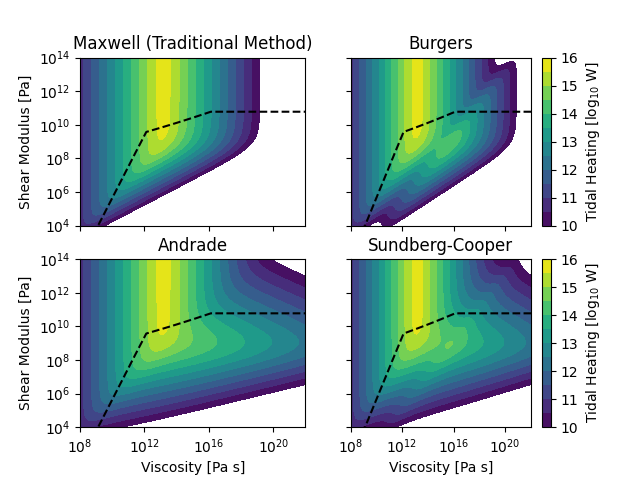

In [6]:
# Setup Plot
fig3, axis_set = plt.subplots(nrows=2, ncols=2, sharex='all', sharey='all')
((ax3_1, ax3_2), (ax3_3, ax3_4)) = axis_set
axes = [ax3_1, ax3_2, ax3_3, ax3_4]

viscosity_array = np.logspace(8, 22, 100)
shear_array = np.logspace(4, 14, 110)

# We eventually want a 2D matrix to plot the results, 
#    but currently TidalPy relies on numba which does not support 2D arrays - so we will need
#    to flatten them before calculations.
viscosity_mtx, shear_mtx = np.meshgrid(viscosity_array, shear_array)
shape = viscosity_mtx.shape
viscosity_mtx_flat = viscosity_mtx.flatten()
shear_mtx_flat = shear_mtx.flatten()

# Colorbar slices
colorbar_points = np.linspace(10, 16, 13)
colorbars = dict()

# Use the orbits constructed in the last example
    
def update_fig(andrade_alpha=0.3, andrade_zeta_power=0.):
    
    andrade_zeta = 10. ** andrade_zeta_power
    
    i = 0
    for (rheo_name, rheo_color), orbit in orbit_by_rheo.items():
        
        # Use the orbits constructed in the last example
        io = orbit.tidal_objects[1]
        # Change the andrade parameters based on the interactive interface
        io.mantle.config['rheology']['alpha'] = andrade_alpha
        io.mantle.config['rheology']['zeta'] = andrade_zeta
        io.mantle.reinit()
        
        # Set thermal state
        io.mantle.temperature = None  # Clear the temperature set in the previous cell.
        io.mantle.set_strength(viscosity=viscosity_mtx_flat, shear_modulus=shear_mtx_flat)
        
        # Pull out tidal heating and convert the shape
        tidal_heating = io.tidal_heating_global
        tidal_heating = np.log10(tidal_heating.reshape(shape))

        # Plot results
        axes[i].clear()
        cb_data = axes[i].contourf(viscosity_array, shear_array, tidal_heating, colorbar_points)
        axes[i].set_title(rheo_name)

        # Plot what the current melting model would produce
        axes[i].plot(io_visco_vs_temp, io_shear_vs_temp, color='k', ls='--')

        if i in [1, 3]:
            if i not in colorbars:
                cb = plt.colorbar(cb_data, ax=axes[i])
                cb.set_label('Tidal Heating [log$_{10}$ W]') 
                colorbars[i] = cb
            else:
                cb = colorbars[i]
                cb.update_normal(cb_data)
        i += 1
    ax3_1.set(xlabel='', xscale='log', ylabel='Shear Modulus [Pa]', yscale='log',
              ylim=(1e4, 1e14), xlim=(1e8, 1e22))
    ax3_2.set(xlabel='', xscale='log', ylabel='', yscale='log',
              ylim=(1e4, 1e14), xlim=(1e8, 1e22))
    ax3_3.set(xlabel='Viscosity [Pa s]', xscale='log', ylabel='Shear Modulus [Pa]', yscale='log',
              ylim=(1e4, 1e14), xlim=(1e8, 1e22))
    ax3_4.set(xlabel='Viscosity [Pa s]', xscale='log', ylabel='', yscale='log',
              ylim=(1e4, 1e14), xlim=(1e8, 1e22))


print('Vary Andrade Parameters')
interact(update_fig,
         andrade_alpha=widgets.FloatSlider(min=0.0, max=1.0, step=0.05, description='$\\alpha$', value=0.3),
         andrade_zeta_power=widgets.FloatSlider(min=-10., max=10., step=1, description='$\\zeta=10^{x}$', value=0.))